In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3    ## SQL Interface
import pickle     ## Used to save your data - Converts objects to byte stream and vice versa

from sklearn.feature_extraction.text import CountVectorizer  ## BOW Model
from sklearn.feature_extraction.text import TfidfVectorizer  ## TFIDF Model

from sklearn.naive_bayes import BernoulliNB      #Bernoulli NB
from sklearn.naive_bayes import MultinomialNB    #Multinomial NB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
conn = sqlite3.connect('final3.sqlite')  #Loading the sqlite file for future use
final = pd.read_sql_query("""SELECT * FROM Reviews""", conn)
conn.close()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedNoStem,CleanedSummary
0,540125,B002W08W56,A2STPOZAT37RNE,Betty Baker,1,1,1,1300320000,"Wonderful, but surprised to find this size can...",Great beans....the best texture hands down. T...,great bean best textur hand seem great tast do...,great beans best texture hands seem great tast...,wonderful surprised find size
1,31763,B000UXWQMC,A115Y8R40DCT3I,Guy,0,0,1,1345161600,better than expected,I usually buy whole pitted olives and when I b...,usual buy whole pit oliv bought good wasnt who...,usually buy whole pitted olives bought good wa...,better expected
2,509504,B000P09RJA,A2BR8LGC8N6XQD,dj2u,0,4,0,1278374400,Wrong size bars sent,The first shipment was just as ordered. This ...,first shipment order last shipment not bar wen...,first shipment ordered last shipment not bars ...,wrong size bars sent
3,27728,B000K8ESBY,A1RYTIMIWPDJ4O,"Bill Ison ""Bill""",0,0,1,1256169600,Coffee flavoring,"<a href=""http://www.amazon.com/gp/product/B000...",flavour creation coffe flavor tablet french va...,flavour creations coffee flavoring tablets fre...,coffee flavoring
4,128657,B001AVJT0K,AJ6SZ4YAPOOO7,Mwebi,0,0,1,1348099200,They all come running,"I have the pickiest cats, they hate 99/100 kin...",pickiest cat hate kind food better vari otherw...,pickiest cats hate kinds food better vary othe...,come running


In [3]:
negative = final[final['Score']==0][['Score','Time','CleanedSummary','CleanedText']]
positive = final[final['Score']==1][['Score','Time','CleanedSummary','CleanedText']]
data = pd.concat([negative,positive.iloc[:67000,:]],axis=0,ignore_index = True)
data.sort_values('Time',inplace = True)
data.head(10)

,Score,Time,CleanedSummary,CleanedText
89279,1,944092800,entertainingl funny,beetlejuic well written movi everyth excel act...
99092,1,944438400,modern day fairy tale,twist rumplestiskin captur film star michael k...
21840,0,948240000,clamshell edition edited version,alway enjoy movi funni entertain didnt hesit p...
114632,1,951523200,bettlejuice bettlejuice bettlejuice,happen say name three time michael keaten star...
113134,1,961718400,great product,realli good idea final product outstand use de...
64542,1,965779200,must,easi use not make mess offer vibrant color not...
88945,1,966297600,fresh original film master storyteller tim burton,great film dont even know sum first complet or...
76537,1,975974400,needs wilton,sick scad nasti toothpick counter tint concept...
50919,0,992217600,casper ghost,michael keaton bring distinguish characterist ...
8665,0,997228800,great movie terrible dvd,continu amaz shoddi treatment movi get dvd rel...


In [4]:
data['Score'].value_counts()

1    67000
0    57110
Name: Score, dtype: int64

# Bernoulli Naive - Bayes using Binary BoW

In [6]:
bow_vect = CountVectorizer(binary = True)
bow = bow_vect.fit_transform(data['CleanedSummary'].values)

In [7]:
X = bow
y = data['Score'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.7000000000000001.


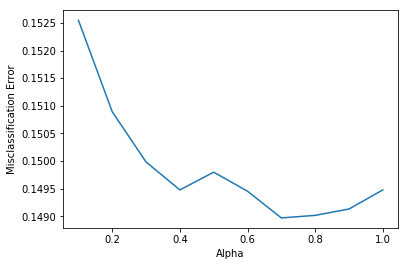

In [9]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = BernoulliNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [10]:
clf = BernoulliNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

85.0455241318


array([[15080,  2364],
       [ 3204, 16585]], dtype=int64)

In [11]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative summaries')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive summaries')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative summaries
not
taste
good
like
product
bad
flavor
dont
great
coffee
disappointed
buy
tastes
tea
price
horrible
terrible
awful
much
money
yuck
poor
worst
made
quality
sweet
beware
really
dog
stale
food
disappointing
better
way
one
ever
didnt
sugar
chocolate
doesnt
waste
expensive
old
wrong
worth
bitter
weak
china
amazon
packaging

******************************

Top 50 words in positive summaries
great
good
best
love
tea
delicious
coffee
product
excellent
taste
yummy
tasty
not
ever
price
flavor
food
favorite
stuff
like
dog
snack
healthy
better
loves
awesome
wonderful
chocolate
perfect
nice
free
yum
dogs
mix
quality
treat
really
one
tastes
tasting
easy
sweet
amazing
hot
cereal
cat
value
buy
fantastic
organic


# Multinomial Naive Bayes using BoW

In [15]:
bow_vect = CountVectorizer()
bow = bow_vect.fit_transform(data['CleanedSummary'].values)

In [16]:
X = bow
y = data['Score'].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is0.7000000000000001.


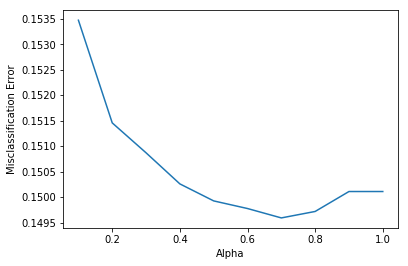

In [18]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = MultinomialNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [19]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

84.9542072892


array([[15061,  2379],
       [ 3223, 16570]], dtype=int64)

In [20]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative summaries')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive summaries')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative summaries
not
taste
good
like
product
bad
flavor
great
dont
coffee
disappointed
buy
tastes
tea
price
horrible
terrible
awful
yuck
much
money
poor
worst
really
made
sweet
quality
stale
dog
beware
food
disappointing
way
better
sugar
one
ever
didnt
chocolate
doesnt
waste
expensive
old
weak
bitter
wrong
worth
china
amazon
get

******************************

Top 50 words in positive summaries
great
good
best
love
tea
delicious
coffee
product
excellent
taste
yummy
tasty
not
ever
price
flavor
food
favorite
stuff
like
dog
snack
healthy
better
loves
chocolate
awesome
wonderful
yum
perfect
nice
free
dogs
mix
quality
really
treat
one
tastes
easy
tasting
sweet
hot
amazing
cat
cereal
value
buy
fantastic
organic


In [21]:
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(data["CleanedSummary"].values)
tf_idf.shape

(124110, 18405)

# Multinomial Naive Bayes using TF - IDF

In [22]:
X = tf_idf
y = data['Score'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)  #Splitting data


 The optimal value of alpha is1.0.


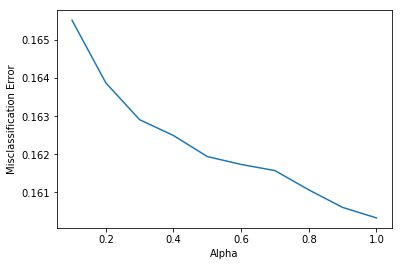

In [24]:
alpha = np.linspace(0.1,1,10)
cv_score = []

for a in alpha:
    clf = MultinomialNB(alpha = a)
    scores = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_score.append(scores.mean())
    
MSE = [1-x for x in cv_score]

optimal_alpha = alpha[MSE.index(min(MSE))]
print('\n The optimal value of alpha is{}.'.format(optimal_alpha))

plt.plot(alpha, MSE)
plt.xlabel('Alpha')
plt.ylabel('Misclassification Error')
plt.show()

In [25]:
clf = MultinomialNB(alpha = optimal_alpha)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred, normalize = True)*float(100)
print(acc)
confusion_matrix(y_test,y_pred).T

83.8986920205


array([[14452,  2163],
       [ 3832, 16786]], dtype=int64)

In [26]:
idx = (-clf.feature_log_prob_).argsort()[:2, :50]
print('Top 50 words in negative summaries')
for i in idx[0]:
    print(bow_vect.get_feature_names()[i])
    
print('\n******************************\n')
print('Top 50 words in positive summaries')
for i in idx[1]:
    print(bow_vect.get_feature_names()[i])

Top 50 words in negative summaries
not
good
taste
disappointed
like
bad
product
dont
flavor
yuck
awful
terrible
horrible
buy
coffee
disappointing
great
tastes
price
stale
money
poor
much
tea
sweet
expensive
worst
beware
really
made
waste
expected
gross
quality
didnt
way
disgusting
bitter
weak
overpriced
nasty
worth
dog
salty
sugar
china
doesnt
wrong
food
better

******************************

Top 50 words in positive summaries
great
good
best
love
delicious
tea
coffee
product
excellent
yummy
tasty
stuff
taste
favorite
price
ever
yum
flavor
awesome
food
dog
wonderful
snack
healthy
loves
perfect
like
not
amazing
better
nice
dogs
chocolate
treat
quality
fantastic
really
value
easy
tasting
free
tastes
mix
cereal
sweet
hot
one
buy
treats
works
